In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'/Users/ab/Documents/expo-fraud-detection/demo_fraud'

In [3]:
data=pd.read_csv("./nonsup_table_20180619.csv", delimiter=",", index_col="mergeall_id")
data.shape

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(100000, 14)

In [4]:
data[-data.investigate_result.isnull()].investigate_result.value_counts()

False positive    869
Fraud             662
Leakage           291
Name: investigate_result, dtype: int64

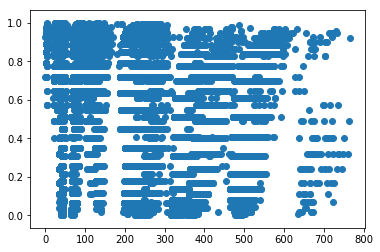

In [5]:
plt.scatter(data.score_cblof, data.score_kmodes_cao)

In [354]:
plt.scatter(data.score_pca_oneSVM, data.score_raphael)

AttributeError: 'DataFrame' object has no attribute 'score_pca_oneSVM'

In [8]:
from Evaluation import evaluation  # this could be replaced by metrics.confusion_matirx

In [7]:
len(data[data.prediction_cblof==-1])

10000

In [10]:
import numpy as np
label_not_null = data[ -data.investigate_result.isnull() ]
y_label = label_not_null.investigate_result.apply(lambda x: -1 if x =="Fraud" else 1)
label_not_null.shape

(1822, 14)

In [359]:
np.sum(list(map(lambda x:1 if x==True else -1, label_not_null.score_cblof<550))==-1)

0

In [362]:
evaluation(np.array(list(map(lambda x:1 if x==True else -1, label_not_null.score_cblof<250))), y_label, normal=1, novelty=-1, verbose=True)

false positive: 473
false negative: 385
true negative: 687
true positive: 277

false positive rate: 0.4077586206896552
recall: 0.41842900302114805
prevision: 0.36933333333333335
specificity: 0.5922413793103448

prevalence: 0.3633369923161361



(473, 385, 277, 687)

(array([175.,  65., 127., 157.,  98.,  31.,   3.,   4.,   1.,   1.]),
 array([ 32.25263917, 101.62303938, 170.99343959, 240.3638398 ,
        309.73424001, 379.10464022, 448.47504044, 517.84544065,
        587.21584086, 656.58624107, 725.95664128]),
 <a list of 10 Patch objects>)

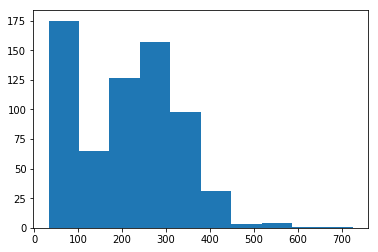

In [363]:
plt.hist(data[data.investigate_result=="Fraud"].score_cblof)

In [364]:
np.sum(data.prediction_isof == -1)

AttributeError: 'DataFrame' object has no attribute 'prediction_isof'

In [11]:
data.columns

Index(['fs1_provider_assisted_himself_score', 'fs2_different_car_plate_score',
       'fs3_appel_police_panne_score', 'kpi1_nb_cases_client_score',
       'kpi2_nb_cases_provider_client_score',
       'kpi3_nb_souscriptions_client_phone_number_score',
       'kpi4_car_renting_days_score', 'weighted_score', 'score_raphael',
       'score_kmodes_cao', 'score_kmodes_huang', 'score_cblof',
       'prediction_cblof', 'investigate_result'],
      dtype='object')

In [12]:
# semisupervised learning

In [13]:
label_not_null["label"] = label_not_null.investigate_result.apply(lambda x:-1 if x=="Fraud" else 1)
label_not_null.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(1822, 15)

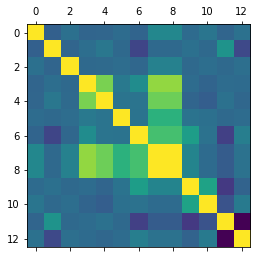

In [14]:
plt.matshow(data.iloc[:, :-1].corr())

In [15]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train,  y_test = train_test_split(label_not_null.iloc[:, :-2], label_not_null.iloc[:, -1], test_size=0.5)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((911, 13), (911,), (911, 13), (911,))

## bayesian ridge

In [18]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [19]:
predictions = np.array(list(map(lambda x:-1 if x else 1, reg.predict(X_test) < 0 )))
evaluation(predictions, y_test)

false positive: 30
false negative: 193
true negative: 562
true positive: 126

false positive rate: 0.05067567567567568
recall: 0.3949843260188088
prevision: 0.8076923076923077
specificity: 0.9493243243243243

prevalence: 0.35016465422612514



(30, 193, 126, 562)

In [22]:
reg.coef_, reg.intercept_

(array([-6.89796341e-02,  2.43522034e-01, -5.24558889e-02, -1.17015739e-01,
         2.51882548e-01, -2.05265778e-01, -5.36982686e-02, -2.01072661e-03,
        -2.01804698e-02,  5.88140301e-01,  8.08174211e-02, -1.93165952e-04,
        -2.69962653e-01]), 1.1041035113193562, [])

## use combining estimators and feature unions

In [23]:
def precision_function(X_test, y_test, reg):
    predictions = np.array(list(map(lambda x:-1 if x else 1, reg.predict(X_test) < 0 )))
    evaluation(predictions, y_test)
    return (np.array(list(map(lambda x:-1 if x else 1, reg.predict(X_test) < 0 ))) == y_test).value_counts()

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


pip = make_pipeline( PCA(n_components=4, copy=True), LogisticRegression())  
pip.fit(X_train, y_train)
(pip.predict(X_test) == y_test).value_counts()

True     675
False    236
Name: label, dtype: int64

<function sklearn.pipeline.Pipeline.score>

In [27]:
pip.steps[0], pip.steps[1]

(('pca',
  PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)))

In [28]:
N_FEATURES_OPTIONS = [2, 4, 8, 10]
C_OPTIONS = [0.5, 0.8, 0.9, 1, 10, 100]
param_grid = [
    {
        'pca': [PCA(iterated_power=7)],
        'pca__n_components': N_FEATURES_OPTIONS,
        'logisticregression__C': C_OPTIONS
    }
]

# randomized search. 

grid_pca_logist = GridSearchCV(pip, cv=10, n_jobs=1, param_grid=param_grid)

grid_pca_logist.fit(X_train, y_train)
precision_function(X_test, y_test, grid_pca_logist)

false positive: 28
false negative: 204
true negative: 564
true positive: 115

false positive rate: 0.0472972972972973
recall: 0.3605015673981191
prevision: 0.8041958041958042
specificity: 0.9527027027027027

prevalence: 0.35016465422612514



True     679
False    232
Name: label, dtype: int64

In [384]:
grid_pca_logist.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power=7, n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [385]:
grid_pca_logist.predict_proba(X_train)

array([[0.82745031, 0.17254969],
       [0.47998859, 0.52001141],
       [0.26436374, 0.73563626],
       ...,
       [0.1310226 , 0.8689774 ],
       [0.66375874, 0.33624126],
       [0.13012805, 0.86987195]])

## pca + svm

In [387]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA, NMF


pipe = Pipeline([
    ('reduce_dim', PCA(whiten=True)),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8, 10, 12]
C_OPTIONS = [0.8, 0.9, 1, 10, 50, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

precision_function(X_test, y_test, grid)

false positive: 25
false negative: 207
true negative: 555
true positive: 124

false positive rate: 0.04310344827586207
recall: 0.37462235649546827
prevision: 0.8322147651006712
specificity: 0.9568965517241379

prevalence: 0.3633369923161361



True     679
False    232
Name: label, dtype: int64

In [389]:
#grid.predict(X_test)

In [390]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [391]:
# random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=4)
clf_rf.fit(X_train, y_train)
precision_function(X_test, y_test, clf_rf)

false positive: 47
false negative: 105
true negative: 545
true positive: 214

false positive rate: 0.07939189189189189
recall: 0.670846394984326
prevision: 0.8199233716475096
specificity: 0.9206081081081081

prevalence: 0.35016465422612514



True     759
False    152
Name: label, dtype: int64

In [31]:
clf_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
from sklearn.metrics import roc_curve, auc

y_prediction = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic RandomForest')
plt.legend(loc="lower right")
plt.show()

NameError: name 'clf' is not defined

false positive: 20
false negative: 38
true negative: 578
true positive: 275

false positive rate: 0.033444816053511704
recall: 0.8785942492012779
prevision: 0.9322033898305084
specificity: 0.9665551839464883

prevalence: 0.34357848518111966



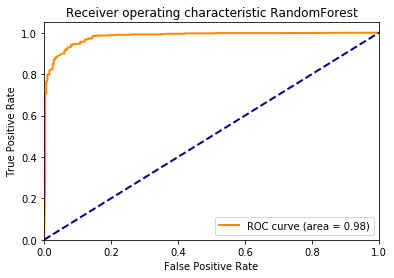

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc


X_train, X_test, y_train,  y_test = train_test_split(label_not_null.iloc[:, :-2], label_not_null.iloc[:, -1], test_size=0.5)

pipe_rf = Pipeline([
    ('randomforest', RandomForestClassifier() )
])

N_FEATURES_OPTIONS = [2, 4, 8, 10, 12]
param_grid = [
    {
        'randomforest__max_depth': N_FEATURES_OPTIONS,
    }
]

grid = GridSearchCV(pipe_rf, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

precision_function(X_test, y_test, grid)

y_prediction = grid.predict(X_test)
y_score = grid.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic RandomForest')
plt.legend(loc="lower right")
plt.show()

In [43]:
grid.best_estimator_   # auto ?

Pipeline(memory=None,
     steps=[('randomforest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

(array([ 20.,  19.,  24.,  17.,  24.,  33.,  43.,  51.,  87., 593.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 10 Patch objects>)

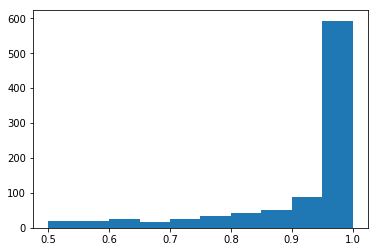

In [397]:
# semi-supervised learning, self-learning
plt.hist(np.max(grid.predict_proba(X_test), axis=1))

In [38]:

def self_learn(X_test, y_test, X_train, y_train, X_unlabel, grid, n_max=10, percent=0.95):
    
    grid.fit(X_train, y_train)
    print("the confusion matrix is:")
    precision_function(X_test, y_test, grid)
    
    X_all = np.concatenate((X_train, X_unlabel))
    new_prediction = grid.predict(X_all)
    for i in range(n_max):
        test_score = grid.score(X_test, y_test)
        train_score = grid.score(X_train, y_train)
        print("n = ", i, "test set score is ", test_score,
              "label train set score is", train_score)
        prediction = new_prediction.copy()  # for stop criteria
        
        # prediction of unlabel part
        prediction_unlabel = grid.predict(X_unlabel)
        # find the confident unlabeled samples and add to labeled ones
        conf_idx = (np.max(grid.predict_proba(X_unlabel), axis=1) >= percent)  
        # update the labeled data and unlabeled data
        new_X_train = np.vstack((X_train, X_unlabel[conf_idx]))
        new_y_train = np.concatenate([y_train, prediction_unlabel[conf_idx]])
        new_X_unlabel = X_unlabel[~conf_idx]
        
        X_train, X_unlabel, y_train = new_X_train, new_X_unlabel, new_y_train
        print("fit data augmented ...")
        grid.fit(X_train, y_train)
        
        new_prediction = grid.predict(X_all)  # for stop criteria
        change_ = np.linalg.norm(x=(new_prediction-prediction), ord=2)/len(prediction)
        if change_ < 1e-4:
            print("change smaller than 1e-4")
            break
        if X_unlabel.shape[0] == 0:
            print("unlabel part vide")
            break
        if test_score > 0.95:
            print("test score good enough")
            break
            
    # test the algorithm
    print("after self-learning, the confusion matrix is")
    precision_function(X_test, y_test, grid)
    y_score = grid.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    


In [39]:
label_not_null = data[ -data.investigate_result.isnull() ]
label_not_null["label"] = label_not_null.investigate_result.apply(lambda x:-1 if x=="Fraud" else 1)
label_null = data[ data.investigate_result.isnull()]
X_train, X_test, y_train,  y_test = train_test_split(label_not_null.iloc[:, :-2], label_not_null.iloc[:, -1], test_size=0.4)
X_unlabel = label_null.iloc[:, :-1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
X_unlabel.shape, X_train.shape, X_test.shape

((98178, 13), (1093, 13), (729, 13))

In [41]:
pipe_rf = Pipeline([
    ('randomforest', RandomForestClassifier() )
])

N_FEATURES_OPTIONS = [2, 4, 8, 10, 12]
param_grid = [
    {
        'randomforest__max_depth': N_FEATURES_OPTIONS,
    }
]
grid = GridSearchCV(pipe_rf, cv=10, n_jobs=1, param_grid=param_grid)
self_learn(X_test, y_test, X_train, y_train, X_unlabel, grid, n_max=10, percent=0.8)

the confusion matrix is:
false positive: 12
false negative: 24
true negative: 460
true positive: 233

false positive rate: 0.025423728813559324
recall: 0.9066147859922179
prevision: 0.9510204081632653
specificity: 0.9745762711864406

prevalence: 0.35253772290809327

n =  0 test set score is  0.9506172839506173 label train set score is 0.9780420860018298
fit data augmented ...


KeyboardInterrupt: 

In [36]:
grid

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'randomforest__max_depth': [2, 4, 8, 10, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
clf

NameError: name 'clf' is not defined

the confusion matrix is:
false positive: 12
false negative: 162
true negative: 452
true positive: 103

false positive rate: 0.02586206896551724
recall: 0.3886792452830189
prevision: 0.8956521739130435
specificity: 0.9741379310344828

prevalence: 0.3635116598079561

n =  0 test set score is  0.7613168724279835 label train set score is 0.7493138151875571
fit data augmented ...
n =  1 test set score is  0.7215363511659808 label train set score is 0.9946916776578248
fit data augmented ...
n =  2 test set score is  0.7530864197530864 label train set score is 0.9968434923845423
fit data augmented ...
n =  3 test set score is  0.7585733882030178 label train set score is 0.9969956300072833
fit data augmented ...
change smaller than 1e-4
after self-learning, the confusion matrix is
false positive: 12
false negative: 164
true negative: 452
true positive: 101

false positive rate: 0.02586206896551724
recall: 0.38113207547169814
prevision: 0.8938053097345132
specificity: 0.9741379310344828

preval

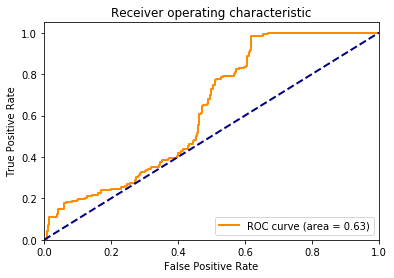

In [404]:
self_learn(X_test, y_test, X_train, y_train, X_unlabel, grid_pca_logist, n_max=10, percent=0.9)

false positive: 12
false negative: 162
true negative: 452
true positive: 103

false positive rate: 0.02586206896551724
recall: 0.3886792452830189
prevision: 0.8956521739130435
specificity: 0.9741379310344828

prevalence: 0.3635116598079561



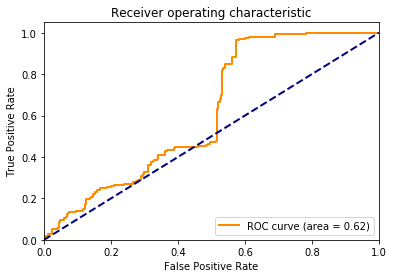

In [406]:
N_FEATURES_OPTIONS = [2, 4, 8, 10]
C_OPTIONS = [0.8, 0.9, 1, 10, 100]
param_grid = [
    {
        'pca': [PCA(iterated_power=7)],
        'pca__n_components': N_FEATURES_OPTIONS,
        'logisticregression__C': C_OPTIONS
    }
]

grid_pca_logist = GridSearchCV(pip, cv=5, n_jobs=1, param_grid=param_grid)
grid_pca_logist.fit(X_train, y_train)
precision_function(X_test, y_test, grid_pca_logist)
y_score = grid_pca_logist.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
#plt.hist(np.max(grid_pca_logist.predict_proba(X_train), axis=1))

## semi-supervised learning prediction impacté par labels distribution

In [44]:
all_predictions = grid.predict(np.vstack([X_train, X_unlabel]))

In [45]:
print(np.unique(all_predictions, return_counts=True))
print(y_train.value_counts())
print(y_test.value_counts())

(array([-1,  1], dtype=int64), array([69117, 29972], dtype=int64))
 1    562
-1    349
Name: label, dtype: int64
 1    598
-1    313
Name: label, dtype: int64


In [ ]:
## add a seuil pour prediction scores: 

In [53]:
confident_preditions = all_predictions[np.max(grid.predict_proba(np.vstack([X_train, X_unlabel])), axis=1) > 0.95]

In [54]:
print(np.unique(confident_preditions, return_counts=True))

(array([-1,  1], dtype=int64), array([ 247, 2182], dtype=int64))


In [415]:
label_not_null.investigate_result.value_counts()

False positive    869
Fraud             662
Leakage           291
Name: investigate_result, dtype: int64

In [56]:
y_test.value_counts()

 1    598
-1    313
Name: label, dtype: int64

In [57]:
np.sum(all_predictions==-1)

69117

In [181]:
### other methods in http://scikit-learn.org/stable/modules/manifold.html#manifold

In [423]:
from sklearn.manifold import TSNE

In [453]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=1000)

In [454]:
tsne_label = tsne.fit_transform(np.vstack([X_train, X_test]))

In [455]:
outliers = (y_train == -1)
tsne_label[outliers].shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1822 but corresponding boolean dimension is 1093

In [ ]:
plt.scatter(tsne_label[:, 0], tsne_label[:, 1])
outliers = tsne_label[(y_train == -1)]
plt.scatter(outliers[:, 0], outliers[:,1])

In [438]:
tsne_data = tsne.fit_transform(np.vstack([X_train, X_unlabel]))

KeyboardInterrupt: 

In [364]:
### other methods for active learning method https://github.com/google/active-learning

In [365]:
# http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html

In [366]:
## simple reinforcement learning